<a href="https://colab.research.google.com/github/saraex6/Transfer-Learning-and-fine-tuning---VGG16-ResNet-50-Inception-V3-/blob/main/Inception_V3_Using_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import os
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

# Define image transformations

In [27]:
BATCH_SIZE = 64
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) 

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 


# Downloading the Dataset

In [28]:
train_data_dir = '/content/gdrive/MyDrive/Train'
test_data_dir = '/content/gdrive/MyDrive/Test'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299, 299),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(299, 299),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)


Found 1022 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


# Using pre-trained layers for feature extraction




In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])                                                                        

In [30]:
#input shape of Inception model
input_shape = (299, 299, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE

In [31]:
pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-kn39bep_
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-kn39bep_


In [32]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot.inputs.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping: monitors the performance of the model and stopping the training process prevents overtraining
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


# Train the model without fine-tuning

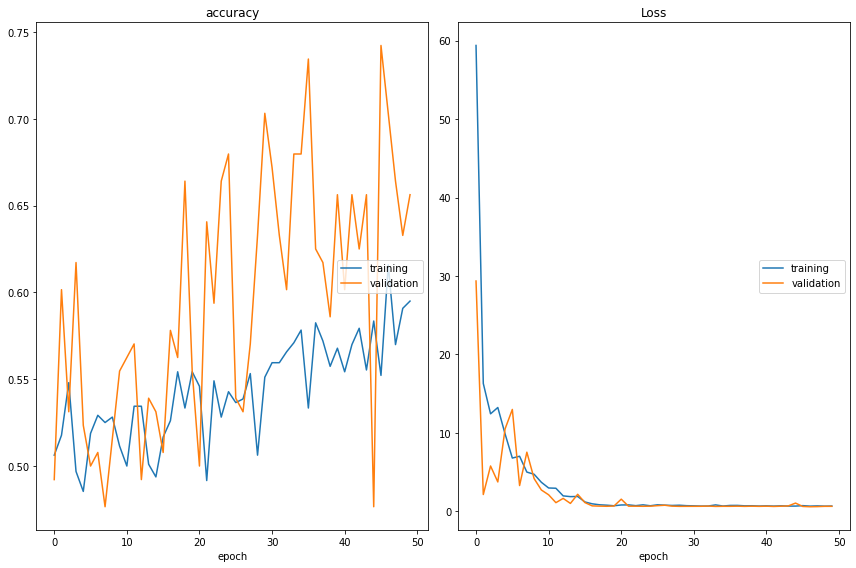

accuracy
	training         	 (min:    0.485, max:    0.616, cur:    0.595)
	validation       	 (min:    0.477, max:    0.742, cur:    0.656)
Loss
	training         	 (min:    0.671, max:   59.374, cur:    0.682)
	validation       	 (min:    0.595, max:   29.359, cur:    0.648)
15/15 [==============================] - 416s 28s/step - loss: 0.6816 - accuracy: 0.5950 - val_loss: 0.6480 - val_accuracy: 0.6562
CPU times: user 9h 53min 57s, sys: 12min 8s, total: 10h 6min 6s
Wall time: 5h 54min 22s


In [33]:
%%time 

Inception_history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=50,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [34]:
# Generate predictions
model.load_weights('tl_model_v1.weights.best.hdf5') #initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

Inception_preds = model.predict(testgen)
Inception_pred_classes = np.argmax(Inception_preds, axis=1)


# Evaluate the performance of Inception V3 using accuracy, F1 Score, precision, recall & loss metrics

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

Inception_acc = accuracy_score(true_classes, Inception_pred_classes)
print("Inception Model accuracy: {:.2f}%".format(Inception_acc * 100))

Inception_f1 = f1_score(true_classes, Inception_pred_classes)
print("Inception Model f1 score: {:.2f}%".format(Inception_f1 * 100))

Inception_precision_score = precision_score(true_classes, Inception_pred_classes)
print("Inception Model precision: {:.2f}%".format(Inception_precision_score * 100))

Inception_recall_score = recall_score(true_classes, Inception_pred_classes)
print("Inception Model recall: {:.2f}%".format(Inception_recall_score * 100))

Inception_log_loss = log_loss(true_classes, Inception_pred_classes)
print("Inception Model loss: {:.2f}%".format(Inception_log_loss ))



Inception Model accuracy: 59.91%
Inception Model f1 score: 53.04%
Inception Model precision: 64.00%
Inception Model recall: 45.28%
Inception Model loss: 13.85%


# Plot confusion matrix 

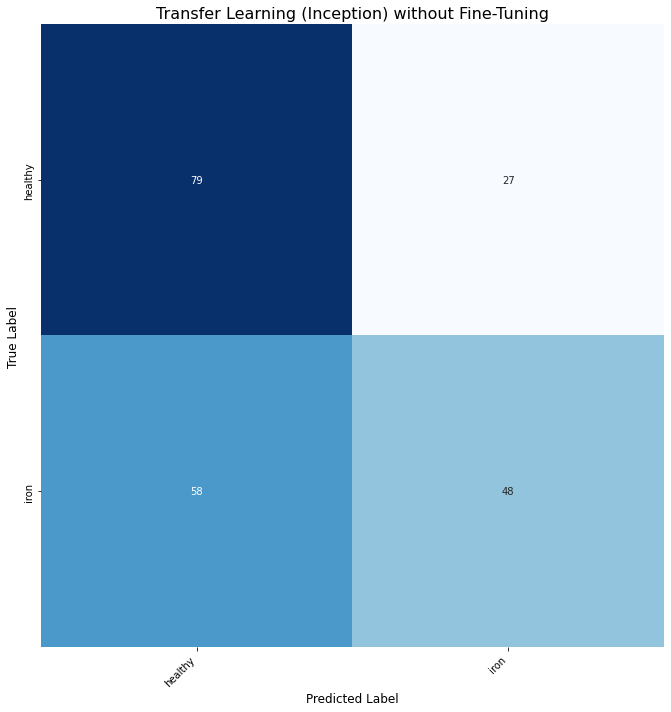

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

# Get the names of the classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2) = plt.subplots(figsize=(20, 10))

plot_heatmap(true_classes, Inception_pred_classes, class_names, ax2, title="Transfer Learning (Inception) without Fine-Tuning")    

fig.tight_layout()

plt.show()
